<a href="https://colab.research.google.com/github/hhumayune/Fake-News-Detector/blob/master/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model


# importing dataset
true_path = '/content/drive/MyDrive/News-_dataset/True.csv'
fake_path = '/content/drive/MyDrive/News-_dataset/Fake.csv'

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

In [60]:
# briefly visualizing the datasets
display(true_df)
display(fake_df)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [61]:
# Data preprocessing part
# Data combination
# Adding Labels to both df
true_df['true'] = 1
fake_df['true'] = 0
# Concat. this basically adds true_df and fake_df
df = pd.concat([true_df, fake_df])
# Purifying only keep title
df = df.iloc[:,[0, -1]]
# Shuffling the data
df = shuffle(df).reset_index(drop=True)
# displaying again
display(df)


,title,true
0,Democrat Corey Booker Backs Single-Payer and W...,0
1,Keeping the competition out: Iran startups thr...,1
2,Clinton's IT aide to plead the Fifth in email ...,1
3,Who collects costs for Trump's Taiwan call?,1
4,Obama-Trump meeting 'less awkward' than some m...,1
...,...,...
44893,Boiler Room EP #114 – Psychos In The Compromis...,0
44894,Trump Team Getting Approval On White National...,0
44895,Senate Republican warns of bailout if Puerto R...,1
44896,Trump's 'America First' push not protectionist...,1


In [62]:
# Preprocessing functions for eliminating noise
def preprocess_text(text):
    # Replace characters that are not between a to z or A to Z with whitespace
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert all characters into lower-case ones. This doesnt really matter if you use BERT
    text = text.lower()
    # Remove inflectional morphemes like "ed", "est", "s", and "ing" from their token stem
    text = re.sub('(ed|est|s|ing)$', '', text)
    return text

# Apply preprocessing to the title column
df['title'] = df['title'].apply(preprocess_text)
display(df)

,title,true
0,democrat corey booker backs single payer and w...,0
1,keeping the competition out iran startups thr...,1
2,clinton s it aide to plead the fifth in email ...,1
3,who collects costs for trump s taiwan call,1
4,obama trump meeting less awkward than some m...,1
...,...,...
44893,boiler room ep psychos in the compromis...,0
44894,trump team getting approval on white national...,0
44895,senate republican warns of bailout if puerto r...,1
44896,trump s america first push not protectionist...,1


In [63]:
#  Splitting the Dataset into Training, Validation, Test 

train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.8)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)
     

trainset size: (28734, 2)
valset size: (7184, 2)
testset size: (8980, 2)


In [64]:
# dataset to csv
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

# concat again
df = pd.concat([train_df, val_df, test_df])
display(df)

,title,true
0,china says south china sea not an issue betwee...,1
1,madness in berkeley anarchists clash with tru...,0
2,trump was being a gentleman uk s may says on ...,1
3,donald trump reveals the first thing he d do ...,0
4,pass the popcorn bill clinton incensed by n...,0
...,...,...
8975,eu considers new plan to ease disputes over mi...,1
8976,chip off the old block harvard bound malia ob...,0
8977,obama gives un authority to vet refugee...,0
8978,ted nugent appears at trump rally gropes him...,0


Epoch 1/2
1123/1123 [==============================] - 79s 69ms/step - loss: 0.1282 - accuracy: 0.9524 - val_loss: 0.0747 - val_accuracy: 0.9714
Epoch 2/2
1404/1404 [==============================] - 22s 16ms/step - loss: 0.0286 - accuracy: 0.9916
Test loss: 0.02857404574751854
Test accuracy: 0.9916477203369141


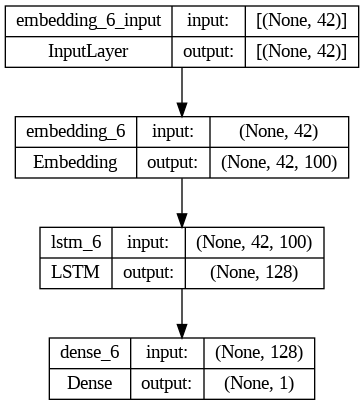

In [66]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['title'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
sequences = tokenizer.texts_to_sequences(df['title'])

#sequence length set to 42
max_sequence_length = 42  

# Pad sequences
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into input (X) and output (y) variables
y = df['true']

# Build the LSTM model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
model.fit(X, y, batch_size=32, epochs=2, validation_split=0.2)
model.save('my_model.h5')

# Load the saved model
loaded_model = load_model('my_model.h5')

# Evaluate the loaded model
print("Test loss:", loss)
print("Test accuracy:", accuracy)


1123/1123 [==============================] - 75s 66ms/step - loss: 0.0167 - accuracy: 0.9943 - val_loss: 0.1065 - val_accuracy: 0.9698


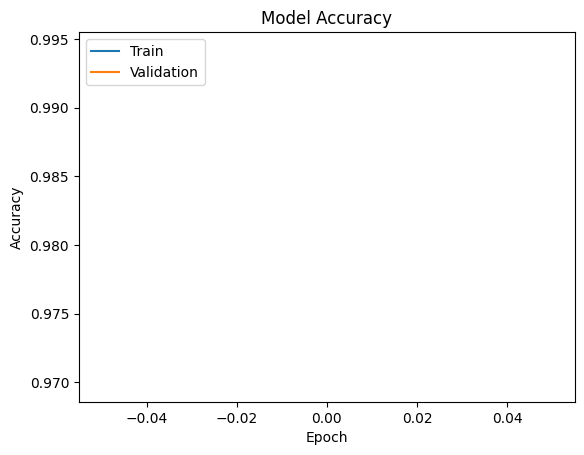

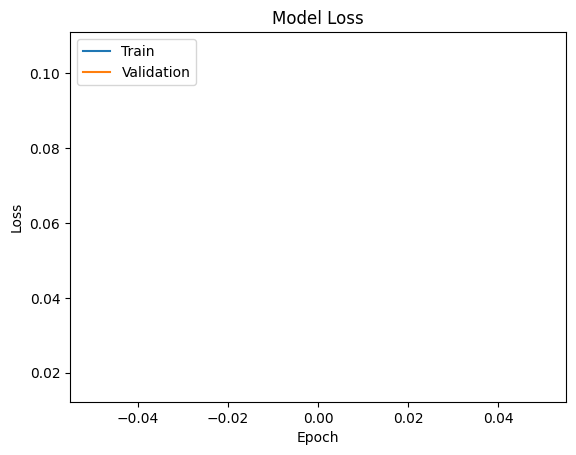

In [75]:
import matplotlib.pyplot as plt

# Get the training history
history = model.fit(X, y, batch_size=32, epochs=1, validation_split=0.2)

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [90]:
#For checking results
title_input = input("Enter a news title: ")

# Preprocess the title
preprocessed_title = preprocess_text(title_input)

# Tokenize and pad the preprocessed title
sequence = tokenizer.texts_to_sequences([preprocessed_title])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

# Predict the authenticity of the title
prediction = loaded_model.predict(padded_sequence)[0]

# Print the result
if prediction >= 0.5:
    print("The news is true.")
else:
    print("The news is fake.")


Enter a news title: who collects costs for trump s taiwan call	
1/1 [==============================] - 0s 19ms/step
The news is true.
